# Caderno 10 - Calcula métricas considerando os resultados de pesquisa em um BM25 com expansão de documentos usando sinônimos gerados pelo GPT e pelo Llama para as palavras mais relevantes encontradas no enunciados

Nota: Esse caderno é praticamente igual ao caderno 8. O que muda é basicamente o a origem dos arquivos gerados e a ideia do que é indexado (no caderno 8 os enunciados são reescritos, neste caderno são gerados alguns sinônimos para as palavras mais relevantes dos enunciados).

In [1]:
# Se True, refaz a indexação. Se False, tenta recuperar o
# índice do arquivo indice_js_enunciado_e_excerto.pickle.
# É necessário que esse arquivo exista.
REINDEXAR_SINONIMOS_ENUNCIADO_EXCERTO_LLAMA = False
REINDEXAR_SINONIMOS_ENUNCIADO_EXCERTO_GPT = False

PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/10_metricas_bm25_com_sinonimos_enunciado_gpt_llama/'
NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto_e_sinonimos_enunciado_gpt.pickle'
NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_LLAMA = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto_e_sinonimos_enunciado_llama.pickle'

# 1. Carrega base de dados

Carrega a lista de documentos para indexar, as queries para testar e o qrels.

In [2]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

Carrega a expansão das queries gerada no caderno anterior:

In [3]:
import pickle

PASTA_CADERNO_REESCRITA_GPT_LLAMA = f'{PASTA_DADOS}outputs/9_sinonimos_enunciado_gpt_llama/'
NOME_ARQUIVO_RESULTADO_LLAMA = f'{PASTA_CADERNO_REESCRITA_GPT_LLAMA}sinonimos_enunciados_llama.pickle'
NOME_ARQUIVO_RESULTADO_GPT = f'{PASTA_CADERNO_REESCRITA_GPT_LLAMA}sinonimos_enunciados_gpt.pickle'

with open(NOME_ARQUIVO_RESULTADO_LLAMA, 'rb') as f:
    enunciado_llama_por_doc = pickle.load(f)
with open(NOME_ARQUIVO_RESULTADO_GPT, 'rb') as f:
    enunciado_gpt_por_doc = pickle.load(f)

Insere a reescrita no dataframe de documentos.

In [4]:
docs['ENUNCIADO_LLAMA'] = docs['KEY'].map(lambda key: enunciado_llama_por_doc[key])
docs['ENUNCIADO_GPT'] = docs['KEY'].map(lambda key: enunciado_gpt_por_doc[key])

# 2. Instancia um BM25 e indexa os campos ENUNCIADO e EXCERTO e as queries expandidas

In [5]:
from bm25 import IndiceInvertido, BM25, tokenizador_pt_remove_html

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [7]:
import os

# Vamos criar um índice invertido e indexar o enunciado, excerto e o enunciado gerado com o Llama
iidx_expansao_llama = IndiceInvertido(tokenizador_pt_remove_html)

if REINDEXAR_SINONIMOS_ENUNCIADO_EXCERTO_LLAMA or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_LLAMA):
    # Se for indexar a primeira vez:
    # Demora cerca de 40 minutos para indexar
    iidx_expansao_llama.adiciona_dataframe(docs, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['EXCERTO'] + ' ' + row['ENUNCIADO_LLAMA']))
    iidx_expansao_llama.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_LLAMA)
else:
    # Se quiser recuperar de um arquivo:
    iidx_expansao_llama.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_LLAMA)

100%|████████████████████████████████████████████████████████████████████████████| 16045/16045 [33:09<00:00,  8.06it/s]


In [8]:
# Vamos criar um índice invertido e indexar o enunciado, excerto e o enunciado gerado com o GPT
iidx_expansao_gpt = IndiceInvertido(tokenizador_pt_remove_html)

if REINDEXAR_SINONIMOS_ENUNCIADO_EXCERTO_GPT or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT):
    # Se for indexar a primeira vez:
    # Demora cerca de 40 minutos para indexar
    iidx_expansao_gpt.adiciona_dataframe(docs, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['EXCERTO'] + ' ' + row['ENUNCIADO_GPT']))
    iidx_expansao_gpt.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT)
else:
    # Se quiser recuperar de um arquivo:
    iidx_expansao_gpt.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT)

100%|████████████████████████████████████████████████████████████████████████████| 16045/16045 [32:35<00:00,  8.20it/s]


In [9]:
print(iidx_expansao_llama.get_tamanho_medio_docs())
print(iidx_expansao_gpt.get_tamanho_medio_docs())

498.94135244624493
496.3913991897787


In [10]:
buscador_llama = BM25(iidx_expansao_llama, k1=0.82, b=0.68, bias_idf=1)
buscador_gpt = BM25(iidx_expansao_gpt, k1=0.82, b=0.68, bias_idf=1)

# 3. Faz as pesquisas e salva os resultados

In [11]:
col_resultado_query_key_llama=[]
col_resultado_doc_key_llama=[]
col_resultado_rank_llama=[]

col_resultado_query_key_gpt=[]
col_resultado_doc_key_gpt=[]
col_resultado_rank_gpt=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    
    resultados_llama = buscador_llama.pesquisar(query_text)
    resultados_gpt = buscador_gpt.pesquisar(query_text)

    # Llama
    primeiros_50_docs_llama = [tupla_key_score[0] for tupla_key_score in resultados_llama[:50]]
    queries_keys_llama = [query_key] * len(primeiros_50_docs_llama)
    ranking_llama = list(range(1, len(primeiros_50_docs_llama)+1))

    col_resultado_query_key_llama.extend(queries_keys_llama)
    col_resultado_doc_key_llama.extend(primeiros_50_docs_llama)
    col_resultado_rank_llama.extend(ranking_llama)

    # GPT
    primeiros_50_docs_gpt = [tupla_key_score[0] for tupla_key_score in resultados_gpt[:50]]
    queries_keys_gpt = [query_key] * len(primeiros_50_docs_gpt)
    ranking_gpt = list(range(1, len(primeiros_50_docs_gpt)+1))

    col_resultado_query_key_gpt.extend(queries_keys_gpt)
    col_resultado_doc_key_gpt.extend(primeiros_50_docs_gpt)
    col_resultado_rank_gpt.extend(ranking_gpt)


df_resultados_llama = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key_llama,
    "DOC_KEY": col_resultado_doc_key_llama,
    "RANK": col_resultado_rank_llama,
})

df_resultados_gpt = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key_gpt,
    "DOC_KEY": col_resultado_doc_key_gpt,
    "RANK": col_resultado_rank_gpt,
})

In [12]:
from metricas import metricas

df_metricas_llama = metricas(df_resultados_llama, qrels, aproximacao_trec_eval=True)
df_metricas_gpt = metricas(df_resultados_gpt, qrels, aproximacao_trec_eval=True)

## 3.1 Resultados Llama

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.280000,0.274000,0.223000,0.129600,0.112056,0.226258,0.370041,0.532600,0.545000,0.567214,0.570214,0.573123,0.305543,0.309370,0.381159,0.459988
std,14.57738,0.252336,0.182734,0.132176,0.053336,0.096352,0.161398,0.236898,0.253006,0.433572,0.407473,0.403466,0.399379,0.263938,0.226410,0.238769,0.223330
min,1.00000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.039632
25%,13.25000,0.000000,0.100000,0.100000,0.085000,0.000000,0.083333,0.157051,0.314103,0.000000,0.166667,0.166667,0.166667,0.000000,0.113358,0.227149,0.290959
50%,25.50000,0.200000,0.300000,0.250000,0.130000,0.087121,0.200000,0.384615,0.483333,0.500000,0.500000,0.500000,0.500000,0.295370,0.273775,0.364421,0.486057
75%,37.75000,0.400000,0.400000,0.300000,0.180000,0.181818,0.351190,0.461538,0.764423,1.000000,1.000000,1.000000,1.000000,0.481513,0.496327,0.603376,0.640964
max,50.00000,1.000000,0.700000,0.500000,0.220000,0.384615,0.600000,0.818182,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.842749,0.841333,0.841333


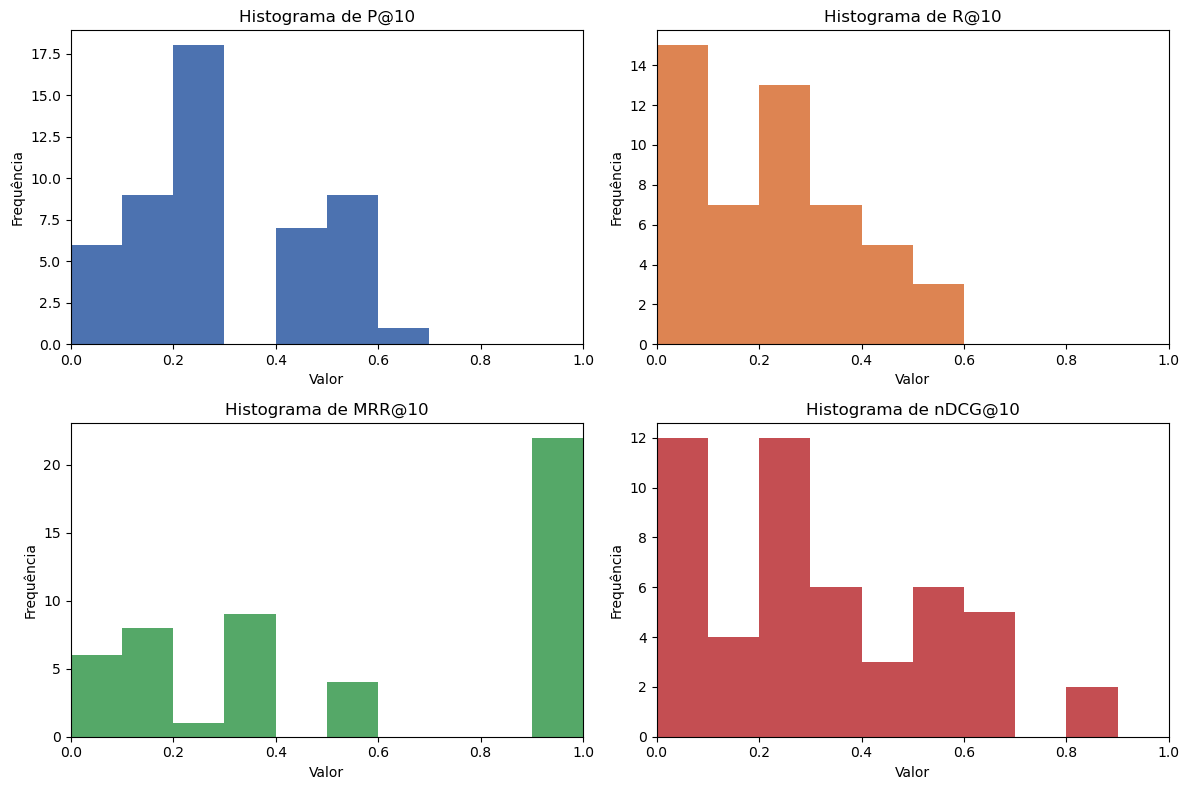

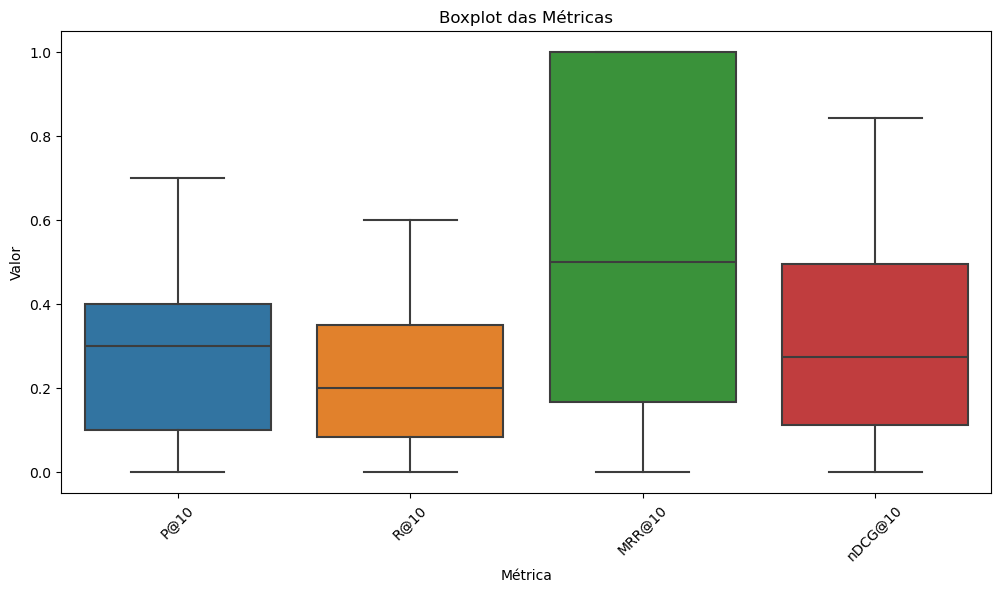

In [13]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries, Llama:
display(df_metricas_llama[0:50].describe())
histograma_metricas(df_metricas_llama[0:50])
boxplot_metricas(df_metricas_llama[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.540000,0.398000,0.269000,0.141600,0.226188,0.334887,0.451173,0.587372,0.906667,0.915079,0.915079,0.915079,0.616164,0.543783,0.581088,0.642360
std,14.57738,0.277746,0.207502,0.132438,0.048796,0.120175,0.189780,0.243021,0.216690,0.267600,0.239179,0.239179,0.239179,0.239912,0.193983,0.198328,0.174086
min,51.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.071429,0.076923,0.083333,0.000000,0.111111,0.111111,0.111111,0.000000,0.083803,0.131600,0.140989
25%,63.25000,0.400000,0.200000,0.150000,0.120000,0.153846,0.180556,0.275974,0.461538,1.000000,1.000000,1.000000,1.000000,0.476016,0.454167,0.436466,0.536173
50%,75.50000,0.600000,0.400000,0.300000,0.160000,0.230769,0.320513,0.428571,0.591667,1.000000,1.000000,1.000000,1.000000,0.647713,0.564441,0.589122,0.661361
75%,87.75000,0.800000,0.500000,0.350000,0.180000,0.326923,0.425595,0.573864,0.750000,1.000000,1.000000,1.000000,1.000000,0.762990,0.670985,0.692433,0.757191
max,100.00000,1.000000,0.800000,0.500000,0.200000,0.454545,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.906178,0.955667,0.955667


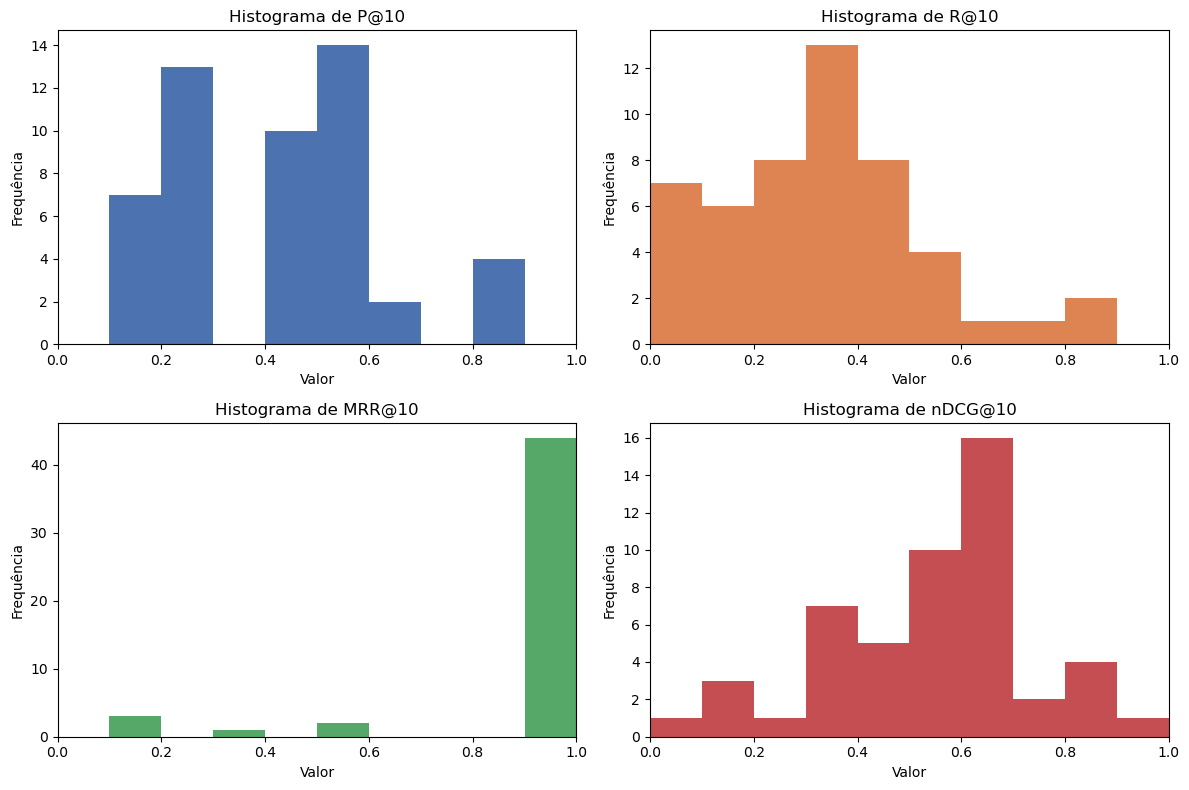

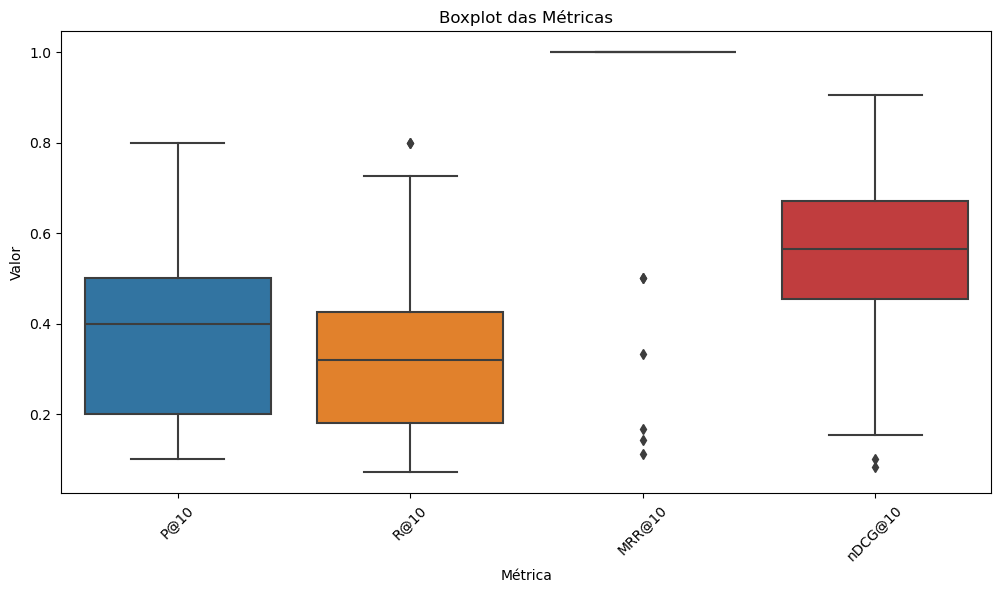

In [14]:
# Resultados para o segundo grupo de queries, Llama:
display(df_metricas_llama[50:100].describe())
histograma_metricas(df_metricas_llama[50:100])
boxplot_metricas(df_metricas_llama[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.528000,0.392000,0.268000,0.138800,0.237200,0.349052,0.475571,0.612368,0.910000,0.912222,0.912222,0.912222,0.612101,0.537835,0.588798,0.643618
std,14.57738,0.254783,0.191493,0.119847,0.050209,0.123152,0.171769,0.214540,0.222041,0.235606,0.227223,0.227223,0.227223,0.217724,0.186440,0.182901,0.169933
min,101.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.066667,0.090909,0.100000,0.000000,0.111111,0.111111,0.111111,0.000000,0.116401,0.284040,0.287107
25%,113.25000,0.400000,0.200000,0.200000,0.100000,0.166667,0.207692,0.326923,0.471154,1.000000,1.000000,1.000000,1.000000,0.464948,0.418351,0.464569,0.503574
50%,125.50000,0.500000,0.400000,0.250000,0.140000,0.218254,0.333333,0.500000,0.625874,1.000000,1.000000,1.000000,1.000000,0.612955,0.536031,0.596581,0.655460
75%,137.75000,0.800000,0.500000,0.350000,0.180000,0.333333,0.459790,0.583333,0.750000,1.000000,1.000000,1.000000,1.000000,0.785210,0.671436,0.719544,0.771612
max,150.00000,1.000000,0.800000,0.500000,0.220000,0.500000,0.727273,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.882608,0.947500,0.947500


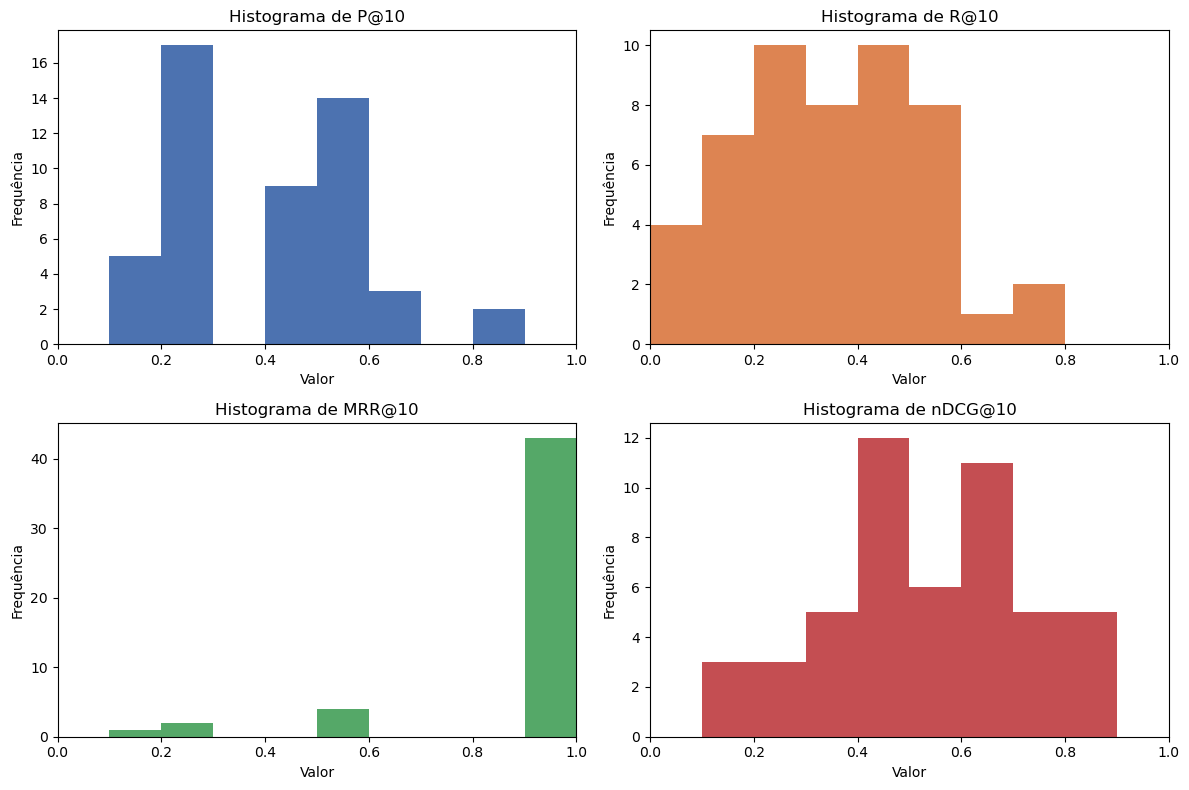

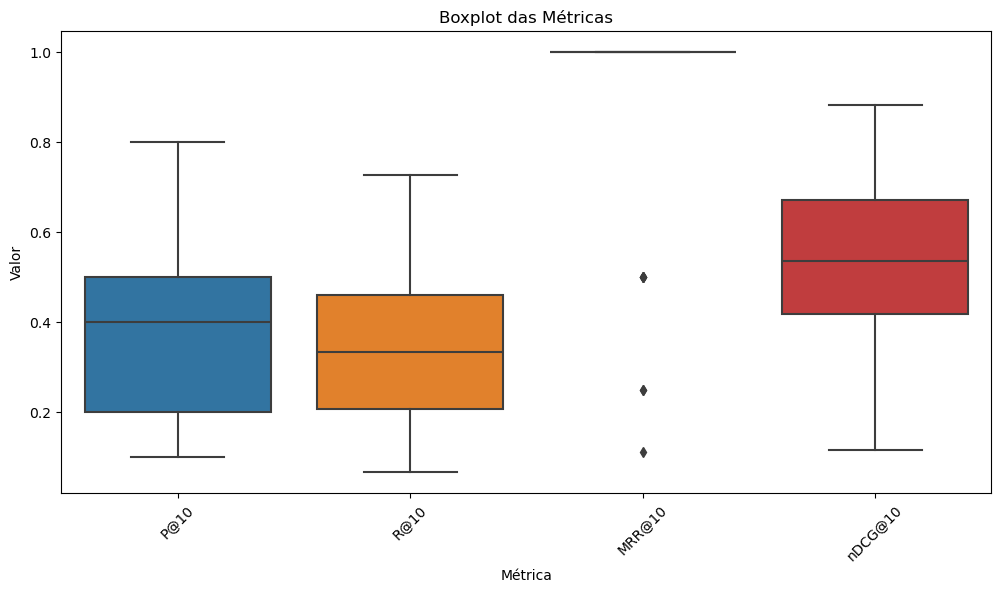

In [15]:
# Resultados para o terceiro grupo de queries, Llama:
display(df_metricas_llama[100:150].describe())
histograma_metricas(df_metricas_llama[100:150])
boxplot_metricas(df_metricas_llama[100:150])

## 3.2 Resultados GPT

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.00000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.30000,0.266000,0.223000,0.13080,0.120047,0.219488,0.370038,0.537576,0.560000,0.572913,0.580826,0.582648,0.318071,0.306573,0.381236,0.461594
std,14.57738,0.26573,0.192311,0.127859,0.05631,0.101552,0.167210,0.230824,0.261909,0.425265,0.409489,0.398763,0.396115,0.264306,0.229854,0.234253,0.229791
min,1.00000,0.00000,0.000000,0.000000,0.02000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.034066
25%,13.25000,0.05000,0.100000,0.100000,0.10000,0.016667,0.078526,0.166667,0.333333,0.062500,0.187500,0.187500,0.187500,0.033210,0.119532,0.224679,0.272843
50%,25.50000,0.20000,0.250000,0.250000,0.12000,0.095455,0.200000,0.384615,0.535897,0.500000,0.500000,0.500000,0.500000,0.327202,0.266609,0.348367,0.478504
75%,37.75000,0.40000,0.400000,0.300000,0.18000,0.181818,0.351190,0.461538,0.764423,1.000000,1.000000,1.000000,1.000000,0.485229,0.485509,0.540457,0.655176
max,50.00000,1.00000,0.700000,0.500000,0.22000,0.384615,0.600000,0.818182,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.842749,0.841333,0.841333


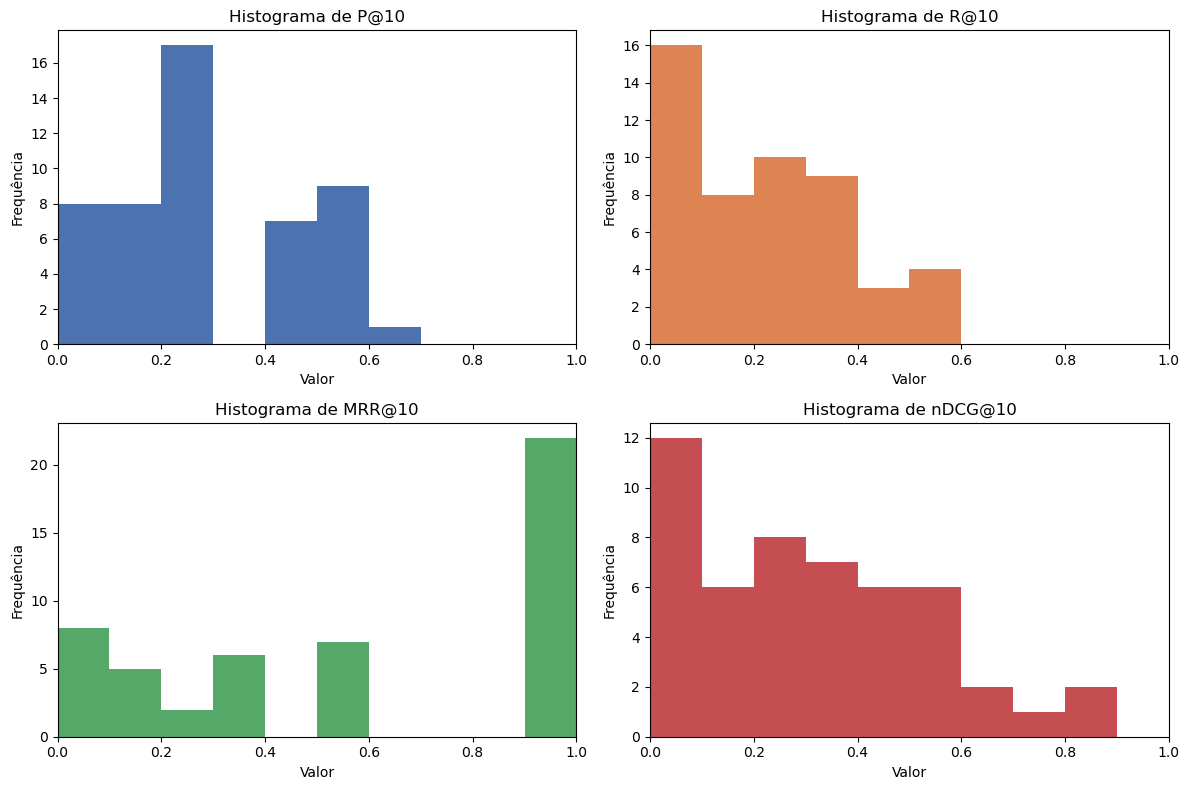

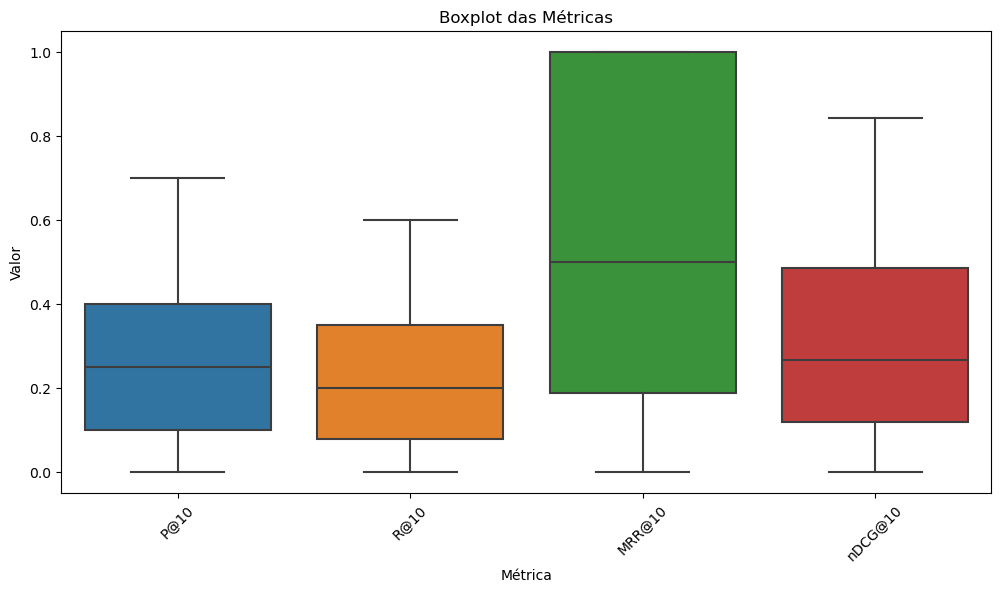

In [16]:
# Resultados para o primeiro grupo de queries, GPT:
display(df_metricas_gpt[0:50].describe())
histograma_metricas(df_metricas_gpt[0:50])
boxplot_metricas(df_metricas_gpt[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.548000,0.394000,0.277000,0.14520,0.228875,0.331930,0.464437,0.604005,0.888333,0.897222,0.897222,0.897222,0.621433,0.543107,0.588203,0.649307
std,14.57738,0.285171,0.213245,0.121727,0.04639,0.123988,0.194652,0.223673,0.210678,0.288484,0.261559,0.261559,0.261559,0.250366,0.201148,0.196286,0.178846
min,51.00000,0.000000,0.100000,0.050000,0.02000,0.000000,0.071429,0.083333,0.083333,0.000000,0.111111,0.111111,0.111111,0.000000,0.083803,0.150664,0.150664
25%,63.25000,0.400000,0.225000,0.162500,0.12000,0.153846,0.224359,0.307692,0.461538,1.000000,1.000000,1.000000,1.000000,0.481475,0.402388,0.498932,0.571324
50%,75.50000,0.600000,0.400000,0.300000,0.16000,0.230769,0.307692,0.458042,0.615385,1.000000,1.000000,1.000000,1.000000,0.652667,0.584555,0.591633,0.667067
75%,87.75000,0.800000,0.500000,0.350000,0.18000,0.307692,0.425595,0.583333,0.750000,1.000000,1.000000,1.000000,1.000000,0.785713,0.684741,0.691875,0.773723
max,100.00000,1.000000,0.800000,0.500000,0.20000,0.500000,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.906178,0.903050,0.951704


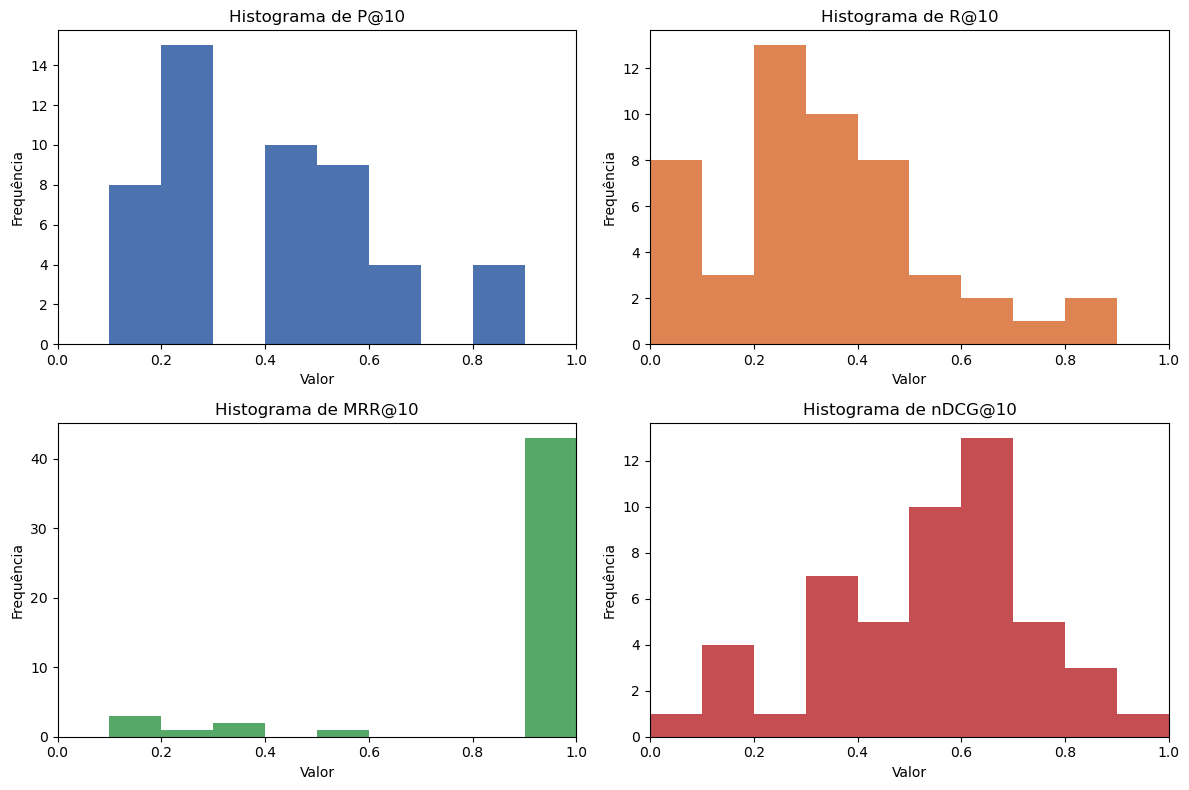

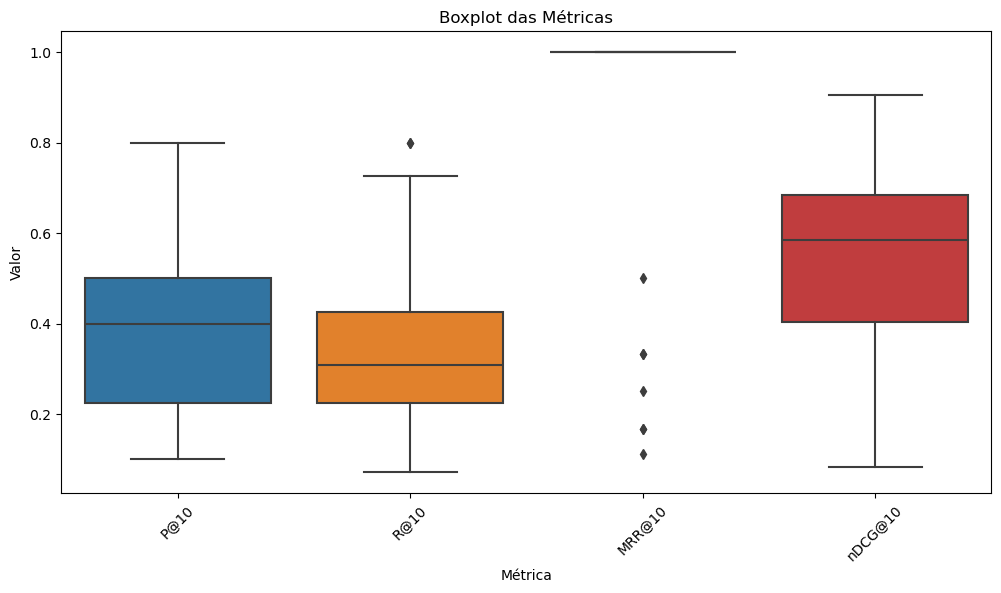

In [17]:
# Resultados para o segundo grupo de queries, GPT:
display(df_metricas_gpt[50:100].describe())
histograma_metricas(df_metricas_gpt[50:100])
boxplot_metricas(df_metricas_gpt[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.516000,0.382000,0.268000,0.138000,0.231366,0.339996,0.474108,0.608755,0.926667,0.928889,0.928889,0.928889,0.604104,0.529483,0.585803,0.640883
std,14.57738,0.255838,0.189187,0.122791,0.052722,0.122384,0.168470,0.216383,0.231682,0.210711,0.201106,0.201106,0.201106,0.216790,0.180410,0.182285,0.170959
min,101.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.066667,0.090909,0.100000,0.000000,0.111111,0.111111,0.111111,0.000000,0.116401,0.237927,0.269553
25%,113.25000,0.400000,0.200000,0.162500,0.100000,0.157051,0.207692,0.340909,0.461538,1.000000,1.000000,1.000000,1.000000,0.480756,0.411506,0.426486,0.509923
50%,125.50000,0.400000,0.350000,0.250000,0.140000,0.207143,0.320513,0.500000,0.625874,1.000000,1.000000,1.000000,1.000000,0.607863,0.557025,0.614714,0.663467
75%,137.75000,0.750000,0.500000,0.350000,0.180000,0.333333,0.454545,0.600000,0.792308,1.000000,1.000000,1.000000,1.000000,0.765150,0.663703,0.737864,0.753359
max,150.00000,1.000000,0.800000,0.500000,0.220000,0.500000,0.727273,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.882608,0.947500,0.947500


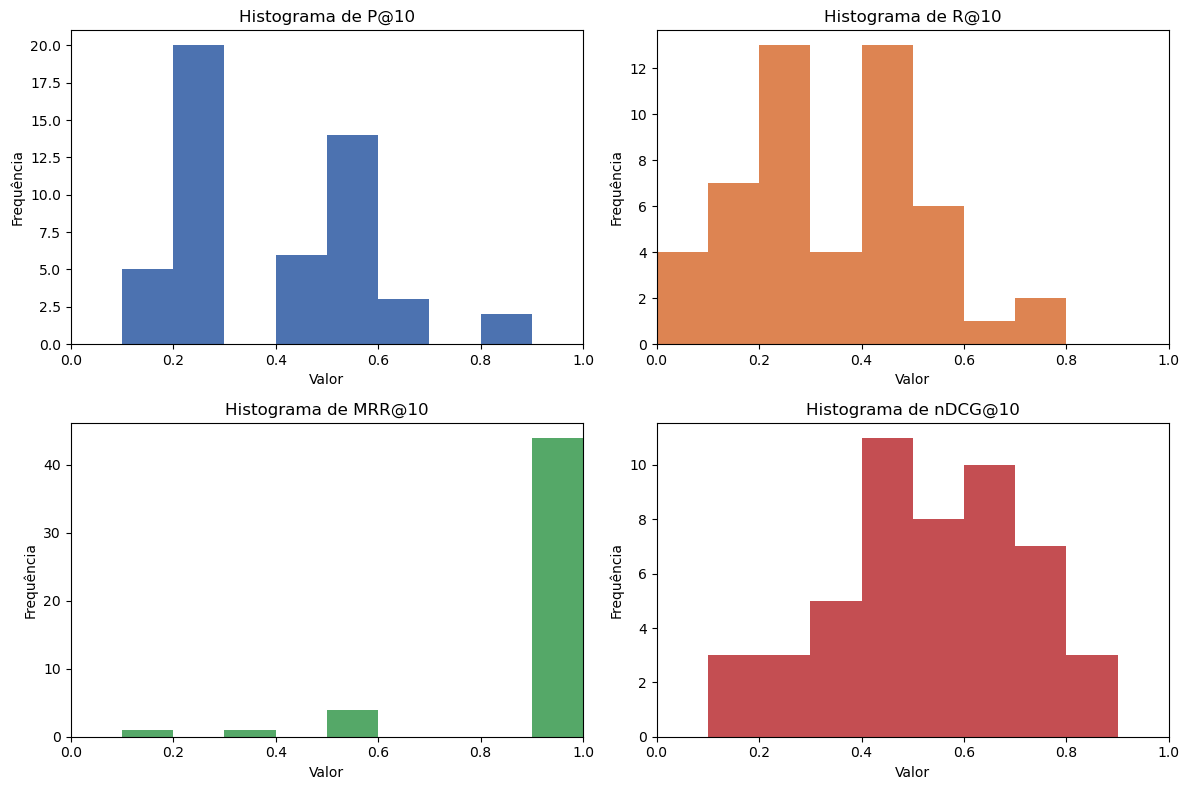

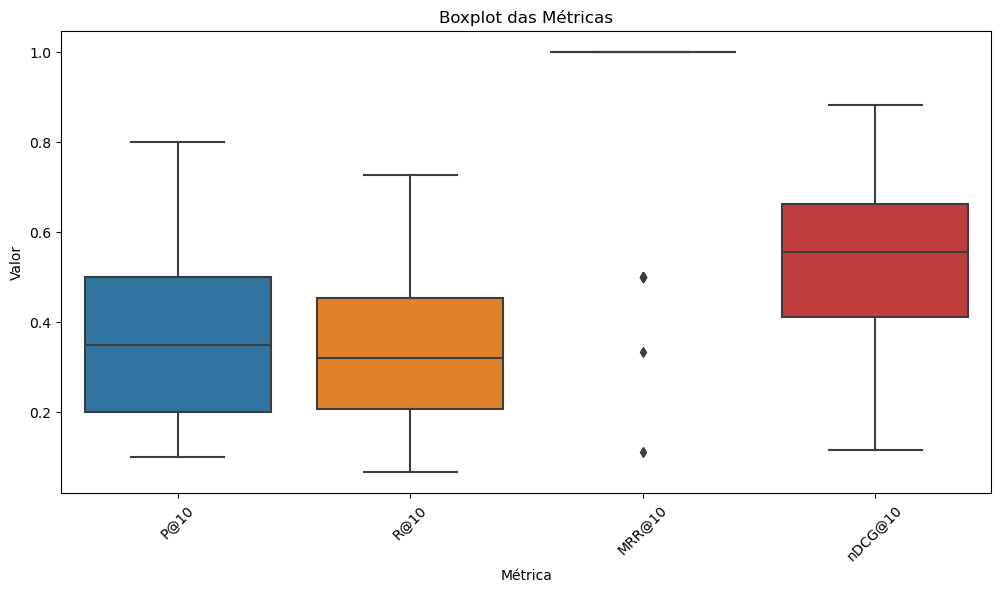

In [18]:
# Resultados para o terceiro grupo de queries, GPT:
display(df_metricas_gpt[100:150].describe())
histograma_metricas(df_metricas_gpt[100:150])
boxplot_metricas(df_metricas_gpt[100:150])